# `Data Cleaning and Basic Exploration`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# load the dataset
file_path = 'data/spotify_million_songs.csv'  # ensure the dataset placed correctly
data = pd.read_csv(file_path)

# inspect the first few rows
print('sample data:\n', data.head())

sample data:
   artist  ...                                               text
0   ABBA  ...  Look at her face, it's a wonderful face  \r\nA...
1   ABBA  ...  Take it easy with me, please  \r\nTouch me gen...
2   ABBA  ...  I'll never know why I had to go  \r\nWhy I had...
3   ABBA  ...  Making somebody happy is a question of give an...
4   ABBA  ...  Making somebody happy is a question of give an...

[5 rows x 4 columns]


In [2]:
# check for duplicates in the dataset
duplicates = data.duplicated(subset=['artist', 'song', 'text']).sum()
print(f'number of duplicate rows: {duplicates}')

number of duplicate rows: 0


In [3]:
# drop duplicates rows if any
data = data.drop_duplicates(subset=['artist', 'song', 'text'])
print(f'data shape after removing duplicates: {data.shape}')

data shape after removing duplicates: (57650, 4)


clean the `text` column by removing unnecessary characters

In [4]:
def clean_text(text):
    text = re.sub(r'\r\n', ' ', text)  # replace link breaks with space
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special characters
    text = text.lower().strip()  # convert to lowercase and strip whitespace
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

In [5]:
# check for empty or very short texts after cleaning
data['text_length'] = data['cleaned_text'].apply(len)
short_texts = data[data['text_length'] < 10]
print(f'number of very short texts (<10 characters): {short_texts.shape[0]}')

number of very short texts (<10 characters): 0


In [6]:
# drop rows with very short texts
data = data[data['text_length'] >= 10]
print(f'data shape after removing short texts: {data.shape}')

data shape after removing short texts: (57650, 6)


`save cleaned data`

In [7]:
cleaned_file_path = 'data/cleaned_spotify_million_songs.csv'
data.to_csv(cleaned_file_path, index=False)
print(f'cleaned data saved to {cleaned_file_path}')

cleaned data saved to data/cleaned_spotify_million_songs.csv


# `Basic Analysis`

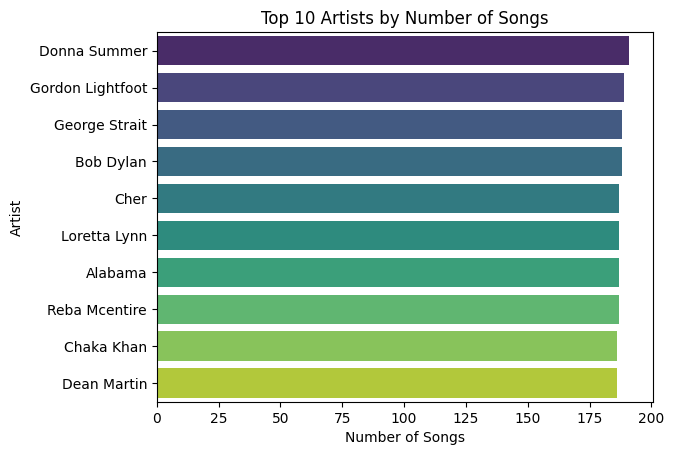

In [8]:
# most common artists
top_artist = data['artist'].value_counts().head(10).reset_index()
top_artist.columns = ['artist', 'count']  # rename for clarity


sns.barplot(data=top_artist, y='artist', x='count', palette='viridis', hue='artist', dodge=False)
plt.title('Top 10 Artists by Number of Songs')
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.legend([],[], frameon=False)  # remove unnecessary legend
plt.show()

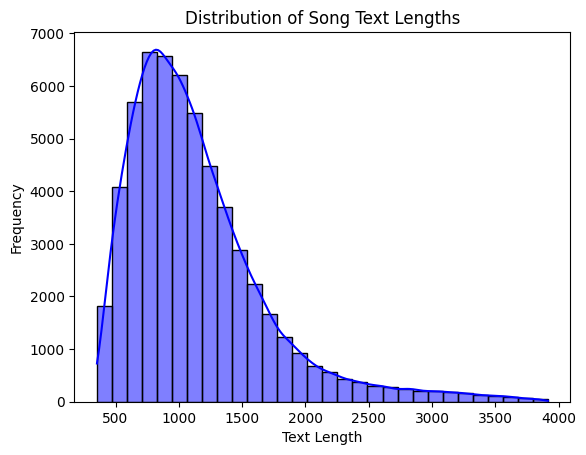

In [9]:
# distribution of song text lengths
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Song Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
import nltk

In [11]:
# download NLTK resources if not already available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

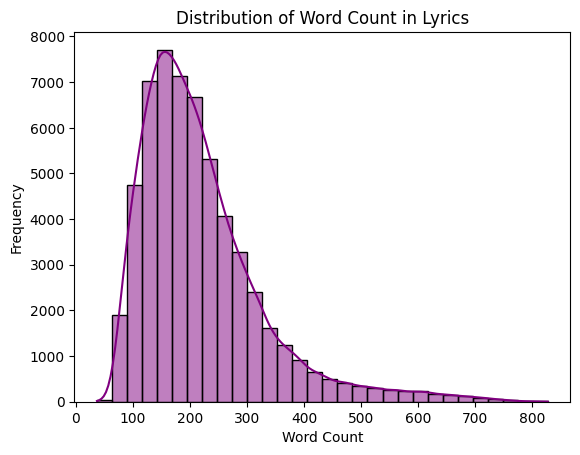

In [12]:
# add a column for word count
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
sns.histplot(data['word_count'], bins=30, kde=True, color='purple')
plt.title('Distribution of Word Count in Lyrics')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

`Preprocess lyrics`

In [13]:
# remove stopwords and generate word frequency
stop_words = set(stopwords.words('english'))
data['processed_text'] = data['text'].apply(
    lambda x: ' '.join(word for word in x.lower().split() if word not in stop_words)
)

In [14]:
# get most common words
all_words = ' '.join(data['processed_text'])
word_freq = Counter(all_words.split())
most_common_words = word_freq.most_common(20)

<ipython-input-15-dbfe30c8b6a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_common_df, x='frequency', y='word', palette='coolwarm')


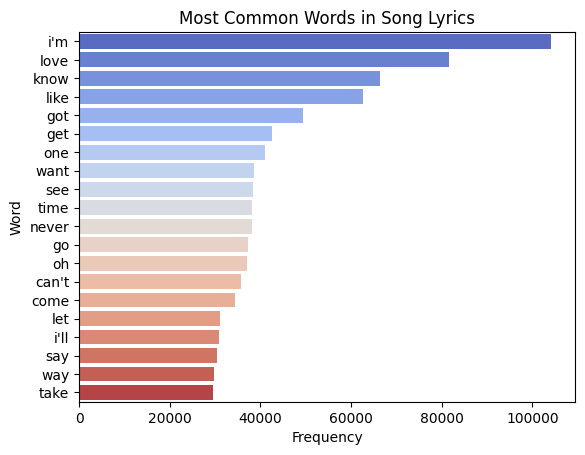

In [15]:
# Bar plot for most frequent words
most_common_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])
sns.barplot(data=most_common_df, x='frequency', y='word', palette='coolwarm')
plt.title('Most Common Words in Song Lyrics')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

`Word Cloud`

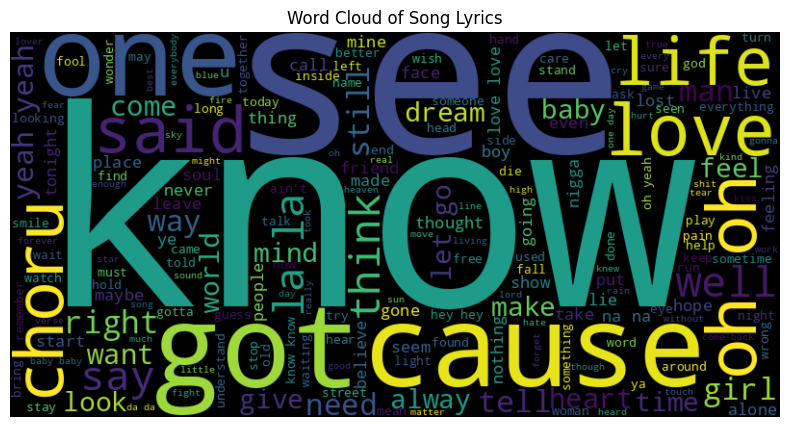

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Song Lyrics')
plt.show()

`Sentiment Analysis`

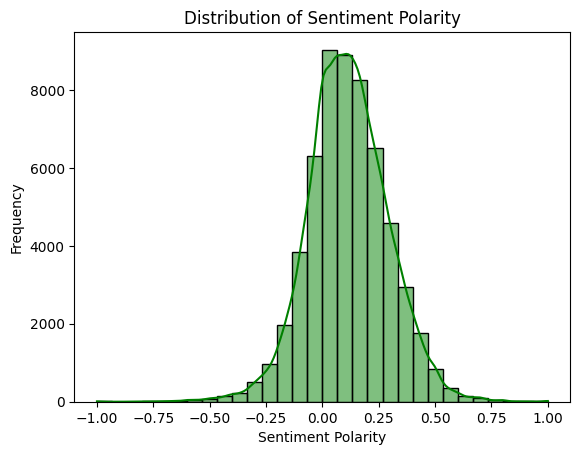

In [17]:
from textblob import TextBlob

data['sentiment'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(data['sentiment'], bins=30, kde=True, color='green')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import numpy as np

# selecting relevant columns
selected_columns = ['artist', 'text', 'word_count', 'sentiment']
feature_data = data[selected_columns]

# lyric-based features: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(feature_data['text'])

# dimensionality reduction for TF-IDF features
svd = TruncatedSVD(n_components=300, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

# encoding categorical features
label_encoder = LabelEncoder()
encoded_artists = label_encoder.fit_transform(feature_data['artist'])

# combining features into a single dataset
# concatenate reduced TF-IDF, word count, sentiment, and encoded artist
final_features = np.hstack([
    reduced_tfidf,
    feature_data['word_count'].values.reshape(-1, 1),
    feature_data['sentiment'].values.reshape(-1, 1),
    encoded_artists.reshape(-1, 1)
])


In [19]:
# save the preprocessed data
preprocessed_path = 'data/preprocessed_features.npy'
np.save(preprocessed_path, final_features)
print(f"Preprocessed features saved to {preprocessed_path}")

Preprocessed features saved to data/preprocessed_features.npy
